In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.2.1')

In [2]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
# SCRATCH_DIR = "./../data"

In [14]:
consolidated_df = pd.read_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

list(consolidated_df.columns)

In [15]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    "Tail_Number",
    "Origin",
    "Dest",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    # "BUILD-CERT-IND", This is only "0", we can drop it
    # 
    # Labels only, duplicates of the airport coordinates, also Origin/Dest
    # "Origin_DISPLAY_AIRPORT_NAME",
    # "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    # "Dest_DISPLAY_AIRPORT_NAME",
    # "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
    #
    # Only concerned with weather delays for this round
    # "DepDel15",
    # "ArrDel15",
    # "CarrierDelay",
    "WeatherDelay",
    # "NASDelay",
    # "SecurityDelay",
    # "LateAircraftDelay",
]


['Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'CRSDepTime',
 'CRSArrTime',
 'CRSElapsedTime',
 'Distance',
 'DistanceGroup',
 'YEAR MFR',
 'HORSEPOWER',
 'THRUST',
 'NO-SEATS',
 'Origin_LATITUDE',
 'Origin_LONGITUDE',
 'Dest_LATITUDE',
 'Dest_LONGITUDE',
 'Reporting_Airline',
 'Tail_Number',
 'Origin',
 'Dest',
 'TYPE REGISTRANT',
 'NAME',
 'CERTIFICATION',
 'TYPE ENGINE',
 'STATUS CODE',
 'MFR',
 'MODEL',
 'TYPE',
 'MFR_aircraft',
 'MODEL_aircraft',
 'TYPE-ENG',
 'BUILD-CERT-IND',
 'Origin_DISPLAY_AIRPORT_NAME',
 'Origin_DISPLAY_AIRPORT_CITY_NAME_FULL',
 'Dest_DISPLAY_AIRPORT_NAME',
 'Dest_DISPLAY_AIRPORT_CITY_NAME_FULL',
 'DepDel15',
 'ArrDel15',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [16]:
weather_df = consolidated_df[num_cols + cat_cols].copy()

weather_df.head()

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,CERTIFICATION,TYPE ENGINE,STATUS CODE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,TYPE-ENG,WeatherDelay
24733033,1,1,4,5,1400,1510,70,190,1,2003.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733034,1,1,4,5,0935,1118,103,438,2,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733035,1,1,4,5,0643,0855,132,513,3,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733036,1,1,4,5,1335,1433,118,576,3,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733037,1,1,4,5,0836,1040,184,896,4,2014.0,...,1T,5,V,GE,CF34-8E5,5.0,EMBRAER S A,ERJ 170-200 LR,5.0,0


In [17]:
weather_df[
    [
        "TYPE REGISTRANT",  # 7 or 3
        # "NAME", # correlated to "Reporting_Airline"
        "CERTIFICATION",  # condense this: (1T, other)
        "TYPE ENGINE",  # 4 or 5
        "STATUS CODE",  # condense this: (V, other)
        "MFR",  # condense this: (GE, CFM INTL, IAE, ROLLS-ROYCE, P & W, other)
        "MODEL",
        "TYPE",  # 4 or 5
        "MFR_aircraft",  # condense this: (BOEING, AIRBUS, BOMBARDIER INC, EMBRAER, MCDONNELL DOUGLAS, other)
        "MODEL_aircraft",
        "TYPE-ENG",  # 4 or 5
    ]
]

,TYPE REGISTRANT,CERTIFICATION,TYPE ENGINE,STATUS CODE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,TYPE-ENG
24733033,3.0,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0
24733034,3.0,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0
24733035,3.0,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0
24733036,3.0,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0
24733037,3.0,1T,5,V,GE,CF34-8E5,5.0,EMBRAER S A,ERJ 170-200 LR,5.0
...,...,...,...,...,...,...,...,...,...,...
32288695,3.0,1T,5,V,CFM INTL,CFM56-5B3/3,5.0,AIRBUS,A321-211,5.0
32288696,3.0,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0
32288697,3.0,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0
32288698,3.0,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0


In [18]:
# BOEING                            2831659
# BOMBARDIER INC                    1262314
# AIRBUS                            1109980
# EMBRAER                            545175
# AIRBUS INDUSTRIE                   544195
# EMBRAER S A                        502448
# MCDONNELL DOUGLAS AIRCRAFT CO      103413
# EMBRAER-EMPRESA BRASILEIRA DE       83212
# MCDONNELL DOUGLAS                   64522
# AIRBUS SAS                          35971
# MCDONNELL DOUGLAS CORPORATION       25896
# C SERIES AIRCRAFT LTD PTNRSP         9258
# AIRBUS CANADA LTD PTNRSP             6573
# CANADAIR                             1948
# GULFSTREAM AEROSPACE CORP             229
# PILATUS AIRCRAFT LTD                   76
# DASSAULT                               75
# GULFSTREAM AEROSPACE                   72
# CESSNA                                 70

weather_df["MFR_aircraft"] = (
    weather_df["MFR_aircraft"]
    .replace(r".*AIRBUS.*", "AIRBUS", regex=True)
    .replace(r".*EMBRAER.*", "EMBRAER", regex=True)
    .replace(r".*MCDONNELL DOUGLAS.*", "MCDONNELL DOUGLAS", regex=True)
    .replace(r".*YABORA.*", "YABORA", regex=True)
)

mfr_aircraft_replacements = {
    "C SERIES AIRCRAFT LTD PTNRSP": "other",
    "CANADAIR": "other",
    "GULFSTREAM AEROSPACE CORP": "other",
    "PILATUS AIRCRAFT LTD": "other",
    "DASSAULT": "other",
    "GULFSTREAM AEROSPACE": "other",
    "CESSNA": "other",
}

weather_df["MFR_aircraft"] = (
    weather_df["MFR_aircraft"].str.strip().replace(mfr_aircraft_replacements)
)

weather_df.value_counts("MFR_aircraft")

MFR_aircraft
BOEING               2831659
AIRBUS               1696719
BOMBARDIER INC       1262314
EMBRAER              1130835
MCDONNELL DOUGLAS     193831
other                  11728
Name: count, dtype: int64

In [19]:
# CERTIFICATION
# 1T            7086132
# 41              10924
# 1N              10000
# 1                8931
# 1A               4097
# 410              2977
# 40               2397
# 4103             1482
# 1C                 76
# 1NU                70

certification_replacements = {
    "41": "other",
    "1N": "other",
    "1": "other",
    "1A": "other",
    "410": "other",
    "40": "other",
    "4103": "other",
    "1C": "other",
    "1NU": "other",
}

weather_df["CERTIFICATION"] = (
    weather_df["CERTIFICATION"].str.strip().replace(certification_replacements)
)

weather_df.value_counts("CERTIFICATION")

CERTIFICATION
1T       7086132
other      40954
Name: count, dtype: int64

In [20]:
# STATUS CODE
# V     7087375
# 25      31022
# 26       5074
# 28       2099
# 27       1516

status_code_replacements = {
    "25": "other",
    "26": "other",
    "28": "other",
    "27": "other",
}

weather_df["STATUS CODE"] = (
    weather_df["STATUS CODE"].str.strip().replace(status_code_replacements)
)

weather_df.value_counts("STATUS CODE")

STATUS CODE
V        7087375
other      39711
Name: count, dtype: int64

In [21]:
# MFR
# GE            2195782
# CFM INTL      2055793
# CFM INTL.     1165502
# IAE            960007
# ROLLS-ROYC     421279
# ROLLS DEUT      19537
# ROLLS-ROY          10
# P & W          287551
# P&W             20128
# P&W CANADA         70
# IVCHENKO         1276
# WILLIAMS           76
# HONEYWELL          75

mfr_replacements = {
    "CFM INTL.": "CFM INTL",
    "ROLLS-ROYC": "ROLLS-ROYCE",
    "ROLLS DEUT": "ROLLS-ROYCE",
    "ROLLS-ROY": "ROLLS-ROYCE",
    "P&W": "P & W",
    "P&W CANADA": "P & W",
    "IVCHENKO": "other",
    "WILLIAMS": "other",
    "HONEYWELL": "other",
}

weather_df["MFR"] = weather_df["MFR"].str.strip().replace(mfr_replacements)

weather_df.value_counts("MFR")

MFR
CFM INTL       3221295
GE             2195782
IAE             960007
ROLLS-ROYCE     440826
P & W           307749
other             1427
Name: count, dtype: int64

In [22]:
weather_df

# 7127086 rows × 33 columns

,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,CERTIFICATION,TYPE ENGINE,STATUS CODE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,TYPE-ENG,WeatherDelay
24733033,1,1,4,5,1400,1510,70,190,1,2003.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733034,1,1,4,5,0935,1118,103,438,2,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733035,1,1,4,5,0643,0855,132,513,3,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733036,1,1,4,5,1335,1433,118,576,3,2002.0,...,1T,5,V,GE,CF34 SERIES,5.0,BOMBARDIER INC,CL-600-2B19,5.0,0
24733037,1,1,4,5,0836,1040,184,896,4,2014.0,...,1T,5,V,GE,CF34-8E5,5.0,EMBRAER,ERJ 170-200 LR,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288695,4,12,1,7,0600,0802,122,762,4,2018.0,...,1T,5,V,CFM INTL,CFM56-5B3/3,5.0,AIRBUS,A321-211,5.0,0
32288696,4,12,1,7,1209,1438,209,1310,6,1999.0,...,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0,0
32288697,4,12,1,7,0650,1110,200,1310,6,1999.0,...,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0,0
32288698,4,12,1,7,1639,1932,293,1851,8,2000.0,...,1T,5,V,P & W,PW2037,5.0,BOEING,757-232,5.0,0


In [3]:
# Checkpoint

# weather_df.to_parquet(f"{SCRATCH_DIR}/weather_features_2019.parquet")

weather_df = pd.read_parquet(f"{SCRATCH_DIR}/weather_features_2019.parquet")

In [4]:
list(weather_df.columns)

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]
cat_cols = [
    "Reporting_Airline",
    "Tail_Number",
    "Origin",
    "Dest",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    #  'WeatherDelay' # convert this to "delayed"
]

weather_df["delayed"] = weather_df["WeatherDelay"].gt(15)

labeled_df = weather_df.drop("WeatherDelay", axis=1)

labeled_df = labeled_df.dropna(axis="index", how=("any"))

labeled_df.value_counts("delayed")
# False    7074065
# True       53021

delayed
False    7037279
True       52754
Name: count, dtype: int64

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


start_time = time.time()

X = labeled_df.drop("delayed", axis=1)
y = labeled_df["delayed"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(), cat_cols),
    ]
)

X_transformed = preprocessor.fit_transform(X)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 48.3881 seconds


In [6]:
from sklearn.model_selection import train_test_split


start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 3.8956 seconds


In [7]:
from imblearn.over_sampling import SMOTE

start_time = time.time()

smote = SMOTE(sampling_strategy=1, random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 1242.5752 seconds


In [10]:
with open(f"{SCRATCH_DIR}/14_weather_2019_X_res_auto.pkl", "wb") as f:
    pickle.dump(X_res, f)

with open(f"{SCRATCH_DIR}/14_weather_2019_y_res_auto.pkl", "wb") as f:
    pickle.dump(y_res, f)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier


def fit_grid_search_gradient_boost(fit_X_train, fit_y_train):
    hist_gb_param_grid = {
        "learning_rate": [0.1], #[0.01, 0.1, 0.5],
        "max_iter": [100], #[50, 100, 200],
        "max_depth": [None], #[None, 10, 20],
        "min_samples_leaf": [40], #[20, 40, 60],
        "l2_regularization": [0], #[0.0, 1.0, 2.0]
    }

    hist_gb_grid_search = GridSearchCV(HistGradientBoostingClassifier(), hist_gb_param_grid, cv=5)

    hist_gb_grid_search.fit(fit_X_train, fit_y_train)

    print("Best HistGradientBoosting parameters: ", hist_gb_grid_search.best_params_)
    print("Best HistGradientBoosting score: ", hist_gb_grid_search.best_score_)
    
    return hist_gb_grid_search

In [8]:
start_time = time.time()

model = fit_grid_search_gradient_boost(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Best HistGradientBoosting parameters:  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 40}
Best HistGradientBoosting score:  0.992322143804134
Elapsed time: 574.2873 seconds


In [9]:
# Checkpoint on the Gradient Boost model

with open(f"{SCRATCH_DIR}/14_weather_delays_gradient_boost.pkl", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/14_weather_delays_gradient_boost.pkl", "rb") as f:
#     model = pickle.load(f)

# Model Evaluation

In [10]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

y_pred = model.predict(X_test)

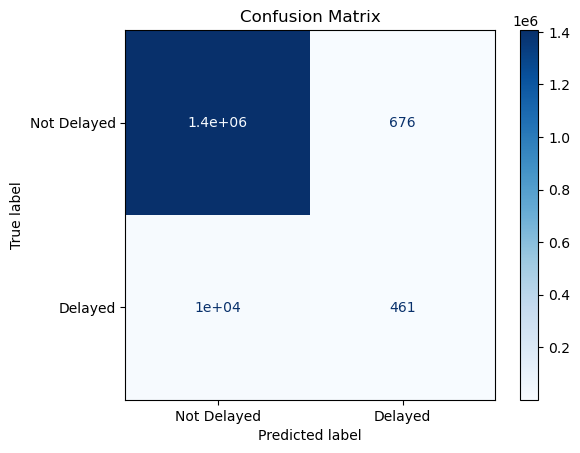

In [11]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [138]:
cm

# DL Confusion Matrix
# array([[97923, 45244],
#        [11049, 20599]])

array([[1225409,  182135],
       [   2756,    7707]])

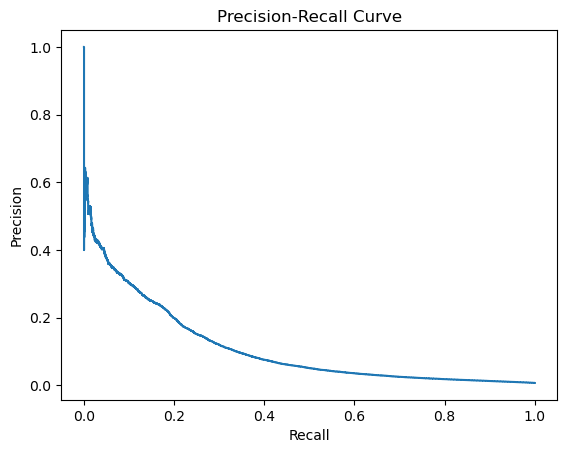

In [12]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [13]:
from sklearn.metrics import roc_auc_score


y_pred_proba = model.best_estimator_.predict_proba(X_test)

ra_score = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

# xgboost
# 0.803598235336136

# gradient boost
# 0.5217898759241941
ra_score

0.5217898759241941

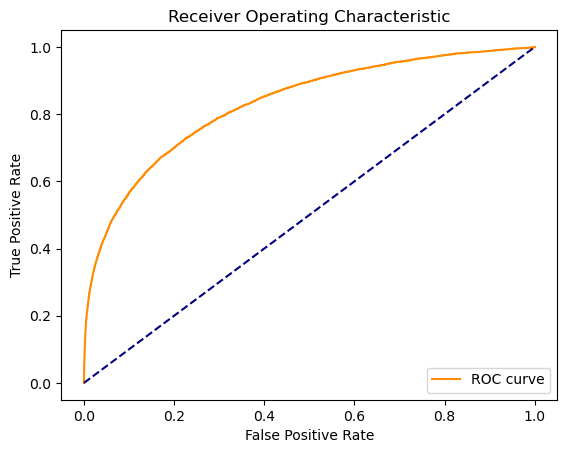

In [16]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [17]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics_scores = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=['Metric', 'Score'])

fig = px.bar(df_metrics, 
             x='Score', 
             y='Metric', 
             orientation='h', 
             color='Metric', 
             text='Score',
             title='Evaluation Metrics')

fig.update_layout(showlegend=False)

fig.show()

In [ ]:
metrics_scores = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

base = alt.Chart(df_metrics).encode(
    y=alt.Y("Metric:N", axis=alt.Axis(title="Metric")),
    x=alt.X("Score:Q", axis=alt.Axis(title="Score"), scale=alt.Scale(domain=[0, 1])),
)

bar = base.mark_bar().encode(color="Metric:N", text=alt.Text("Score:Q", format=".2f"))

text = base.mark_text(
    align="right",
    baseline="middle",
    color="white",
    dx=-10,
).encode(text=alt.Text("Score:Q", format=".2f"))

chart = (
    (bar + text)
    .properties(title="Evaluation Metrics", width=600, height=300)
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

chart